In [1]:
!pip install qiskit==0.43.2 qiskit-machine-learning==0.6.0 qiskit-algorithms==0.2.0 pylatexenc

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [15]:
# STEP 1: Load and preprocess data
def load_data():
    url = "https://raw.githubusercontent.com/SahandNamvar/Binary-classification-Alzheimer-disease/refs/heads/main/alzheimers_disease_data.csv"
    df = pd.read_csv(url)
    df = df.drop(columns=["PatientID"], errors='ignore')
    df = df.dropna(subset=["Diagnosis"])

    numeric_cols = df.drop(columns=["Diagnosis"]).select_dtypes(include=[np.number]).columns.tolist()
    df = df[numeric_cols + ["Diagnosis"]].dropna()

    class_0 = df[df["Diagnosis"] == 0]
    class_1 = df[df["Diagnosis"] == 1]
    min_len = min(len(class_0), len(class_1))
    df_balanced = pd.concat([
        class_0.sample(min_len, random_state=42),
        class_1.sample(min_len, random_state=42)
    ]).sample(frac=1, random_state=42)

    X = df_balanced.drop(columns=["Diagnosis"])[:200]
    y = df_balanced["Diagnosis"][:200]
    return X, y

In [16]:
# STEP 2: Feature importance and selection
def get_top_features(X, y, n_top=2):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = X.columns[indices[:n_top]]

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[indices], y=X.columns[indices])
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.show()

    return list(top_features)

In [17]:
# STEP 3: PCA Visualization
def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=70)
    plt.title("PCA - First Two Principal Components")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
# STEP 4: Classical SVM
def train_svm(X_train, y_train):
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    return svm

In [21]:
# STEP 5: Quantum SVM (QSVM)
def train_qsvm(X_train, y_train, selected_feature_names):
    feature_dim = len(selected_feature_names)
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train)
    return qsvc

In [22]:
# STEP 6: Evaluation
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, y_pred

In [23]:
# STEP 7: ROC Plots
def plot_roc(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

def plot_qsvm_roc(qsvc, X_test, y_test, X_train):
    try:
        kernel_test = qsvc.quantum_kernel.evaluate(X_test, X_train)
        decision_scores = np.sum(kernel_test * qsvc.dual_coef_, axis=1) + qsvc.intercept_

        fpr, tpr, _ = roc_curve(y_test, decision_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Quantum SVM (AUC = {roc_auc:.2f})", color='purple')
    except Exception as e:
        print("⚠️ QSVM ROC Curve could not be plotted:", e)

In [24]:
# STEP 8: Feature Map Visualization
def plot_feature_map(selected_features):
    print("\n🌀 Feature Map (Quantum Circuit):")
    feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=2, entanglement="linear")
    fig = circuit_drawer(feature_map, output='mpl')
    fig.suptitle("ZZ Feature Map", fontsize=14)
    fig.tight_layout()
    fig.show()

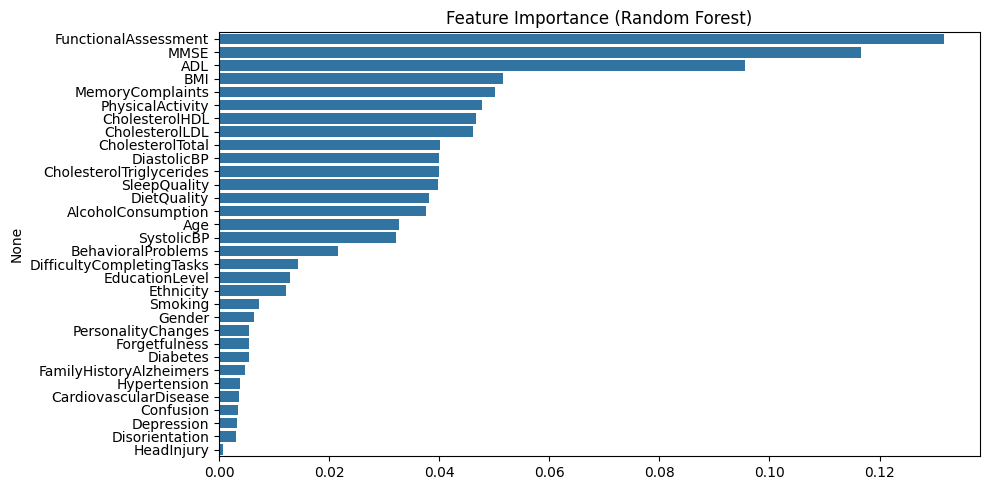

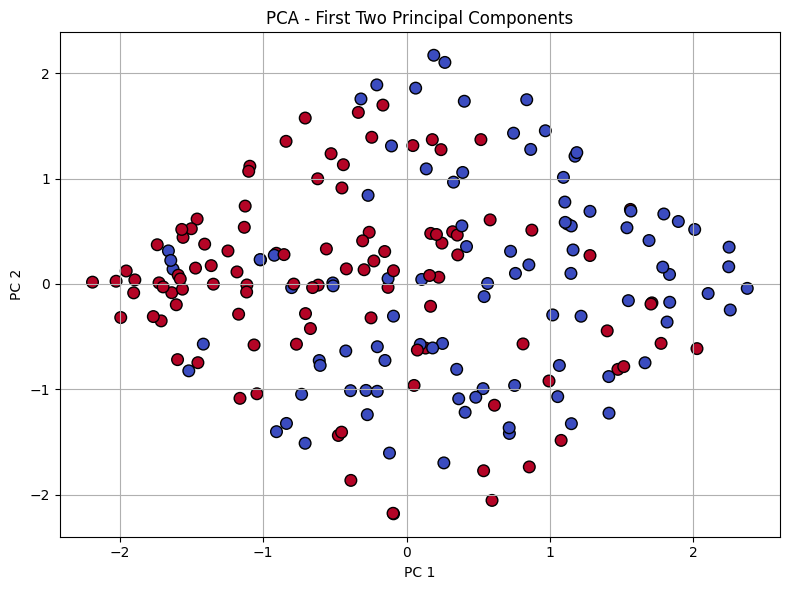


🧠 Training Classical SVM...

✅ Classical SVM Accuracy: 0.7000
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           1       0.72      0.65      0.68        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



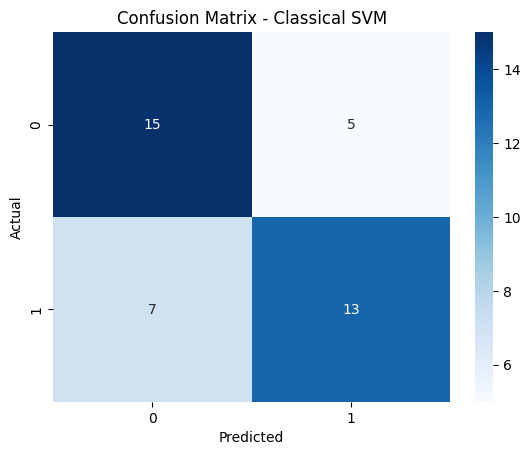


⚛️ Training Quantum SVM...

✅ Quantum SVM Accuracy: 0.4500
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        20
           1       0.46      0.55      0.50        20

    accuracy                           0.45        40
   macro avg       0.45      0.45      0.44        40
weighted avg       0.45      0.45      0.44        40



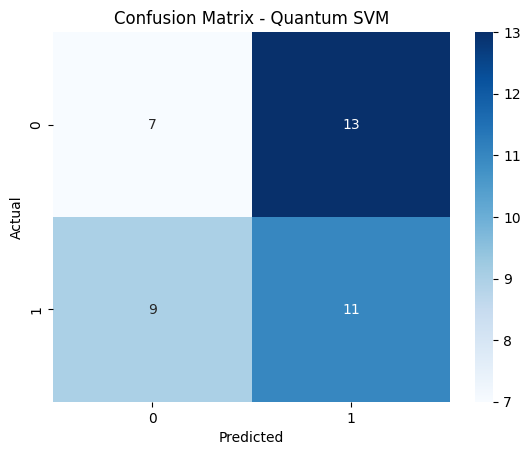

⚠️ QSVM ROC Curve could not be plotted: operands could not be broadcast together with shapes (40,160) (1,144) 


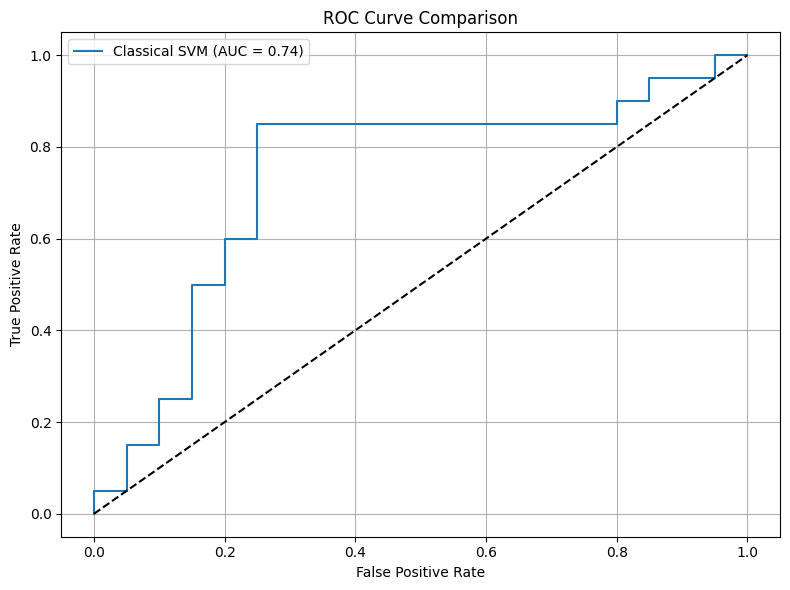


✅ Final Summary:
Classical SVM Accuracy: 0.7000
Quantum SVM Accuracy  : 0.4500


In [25]:
# === MAIN PIPELINE ===
X, y = load_data()
top_features = get_top_features(X, y, n_top=2)
X_top = X[top_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top)

# PCA Visualization
plot_pca(X_scaled, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Classical SVM
print("\n🧠 Training Classical SVM...")
svm_model = train_svm(X_train, y_train)
acc_clf, _ = evaluate_model(svm_model, X_test, y_test, "Classical SVM")

# Quantum SVM
print("\n⚛️ Training Quantum SVM...")
qsvm_model = train_qsvm(X_train, y_train, top_features)
acc_qsvm, _ = evaluate_model(qsvm_model, X_test, y_test, "Quantum SVM")

# ROC Curves
plt.figure(figsize=(8, 6))
plot_roc(svm_model, X_test, y_test, "Classical SVM")
plot_qsvm_roc(qsvm_model, X_test, y_test, X_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print("\n✅ Final Summary:")
print(f"Classical SVM Accuracy: {acc_clf:.4f}")
print(f"Quantum SVM Accuracy  : {acc_qsvm:.4f}")